# PyData Miami 2022 - CFPB Enterprise Semantic Search
09/22/2022

* pydata2022_cfpb_ess.ipynb
* https://pydata.org/miami2022/
* https://nelscorrea.github.io/PyData_Miami_2022


In [1]:
import numpy as np
import pandas as pd
import sklearn as sklearn

import datasets as hfds
import transformers as hf

import tensorflow as tf

import copy, os, re, sys
from datetime import datetime
from umap import UMAP
# from tqdm import tqdm

# import cfpb

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
warnings.filterwarnings("ignore")

In [2]:
print(f"NumPy {np.__version__}, pandas {pd.__version__}, sklearn {sklearn.__version__}")
print(f"HuggingFace Datasets: {hfds.__version__}, Transformers: {hf.__version__}")
print(f"TensorFlow: {tf.__version__}, Keras: {tf.keras.__version__}")

NumPy 1.22.4, pandas 1.4.3, sklearn 1.1.1
HuggingFace Datasets: 1.16.1, Transformers: 4.11.3
TensorFlow: 2.9.1, Keras: 2.9.0


<hr/>

# Document vectorization: - Traditional IR 

* Scikit-Learn text vectorizers (CountVectorizer, TfidfVectorizer)
* Sparse vector representation of documents (document-term matrix, |V|)


In [3]:
import this


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [4]:
# Document collection
dc = {
    "d1":"Simple is better than complex.", 
    "d2":"Complex is better than complicated.", 
    "d3":"Flat is better than nested.", 
    "d4":"Sparse is better than dense."
}

In [5]:
# Sklearn TfidfVectorizer
import sklearn as sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer()

vectorizer.fit(dc.values())
vec_features = vectorizer.get_feature_names()
print(f"Vectorizer features: {len(vec_features)} tokens. \n{', '.join(vec_features)}")

Vectorizer features: 10 tokens. 
better, complex, complicated, dense, flat, is, nested, simple, sparse, than


In [6]:
# TfidfVectorizer: Vectorize documents
DC = vectorizer.transform(dc.values()) # Sparse matrix
pd.DataFrame(DC.toarray(), columns=vec_features)

,better,complex,complicated,dense,flat,is,nested,simple,sparse,than
0,0.334174,0.504879,0.000000,0.000000,0.000000,0.334174,0.000000,0.640375,0.000000,0.334174
1,0.334174,0.504879,0.640375,0.000000,0.000000,0.334174,0.000000,0.000000,0.000000,0.334174
2,0.310920,0.000000,0.000000,0.000000,0.595813,0.310920,0.595813,0.000000,0.000000,0.310920
3,0.310920,0.000000,0.000000,0.595813,0.000000,0.310920,0.000000,0.000000,0.595813,0.310920


## Query document collection (sparse)

In [7]:
# Query vectorize
qc = { "q1":"simple is better", "q2":"better than complex"}

Q = vectorizer.transform(qc.values())
pd.DataFrame(Q.toarray(), columns=vec_features)

,better,complex,complicated,dense,flat,is,nested,simple,sparse,than
0,0.419880,0.000000,0.0,0.0,0.0,0.41988,0.0,0.804612,0.0,0.000000
1,0.483222,0.730064,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.483222


In [8]:
# Search: get top document for Q[qk]
qk = 0; query_key = list(qc.keys())[qk]
scores = DC.dot(Q[qk].toarray()[0].T)  # dot-product DC.Q
max_id = np.argmax(scores)
dk = list(dc.keys())[max_id]

# Top result
print(f"Query:  {qc[query_key]}")
print(f"Top score [{max_id}]: {scores[max_id]}\n\t Scores: {scores}\nDocument  [{max_id}]: {dc[dk]}")
dc

Query:  simple is better
Top score [0]: 0.795879920237181
	 Scores: [0.79587992 0.28062625 0.26109826 0.26109826]
Document  [0]: Simple is better than complex.


{'d1': 'Simple is better than complex.',
 'd2': 'Complex is better than complicated.',
 'd3': 'Flat is better than nested.',
 'd4': 'Sparse is better than dense.'}

# Document vectorization: - Neural model 

* FinBERT, large language model (based on Google BERT-base, 2018)
* FinBERT Trained for financial sentiment analysis - TRC2-financial; Financial PhraseBank; FiQA Sentiment 
* Dense vector representation of documents (768-dim)
* https://arxiv.org/abs/1908.10063 

Alternative models: Multi-QA MPNet, Multi-QA DistilBERT, MPNet
* multi-qa-mpnet-base-dot-v1
* multi-qa-distilbert-cos-v1
* https://www.sbert.net/docs/pretrained_models.html
* https://arxiv.org/abs/2004.09297


In [9]:
# Transformer model
# from transformers import AutoTokenizer, TFAutoModel
model_ckpt = "ProsusAI/finbert"  # BERT trained for financial sentiment analysis
# model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1" # BERT trained for question-answering
tokenizer = hf.AutoTokenizer.from_pretrained(model_ckpt)
model = hf.TFAutoModel.from_pretrained(model_ckpt, from_pt=True)

def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

def get_embeddings(text_list):
    encoded_input = tokenizer(text_list, padding=True, 
                              truncation=True, return_tensors="tf")
    encoded_input = {k: v for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

model.summary()

2022-09-25 09:57:50.389229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['classifier.weight', 'bert.embeddings.position_ids', 'classifier.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initial

Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________


In [10]:
# FinBERT: Vectorize documents
dc_text = list(dc.values())
%time DC_finbert = get_embeddings(dc_text)
pd.DataFrame(DC_finbert, columns=None)

CPU times: user 427 ms, sys: 41.2 ms, total: 468 ms
Wall time: 181 ms


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.190899,0.874197,-1.032465,-0.137693,-0.306911,-0.725966,0.436320,0.340217,1.060956,-1.084645,...,0.058592,-0.362671,-0.018004,-0.426524,-0.887318,0.725826,0.292485,-0.592488,-0.318993,0.670576
1,0.107703,0.896653,-1.145805,-0.081705,-0.417182,-0.801632,0.639703,0.530051,1.056912,-0.929148,...,0.237219,-0.238325,-0.133330,-0.415811,-0.804851,0.369824,0.204125,-0.698620,-0.376128,0.709878
2,0.271673,0.214038,-0.597655,-0.412695,-0.234643,-0.437923,-0.073856,0.258040,0.904815,-0.660722,...,0.194288,-0.090732,0.378461,-0.077305,-0.088105,0.860166,0.172182,-0.629481,0.153705,0.974907
3,0.025600,0.475642,-0.886289,-0.326687,-0.135318,-1.126632,0.167423,0.529638,0.543420,-0.991395,...,0.336393,-0.500228,0.146338,-0.194268,-0.752832,0.533828,0.172110,-0.351772,-0.454405,0.635616


## Query document collection (dense)

In [11]:
# Q_finbert: dense query embeddings
%time Q_finbert = get_embeddings(list(qc.values())).numpy()
print(f"queries: {qc.values()}, query_embedding.shape: {Q_finbert.shape}")
pd.DataFrame(Q_finbert, columns=None)

CPU times: user 292 ms, sys: 16.4 ms, total: 309 ms
Wall time: 144 ms
queries: dict_values(['simple is better', 'better than complex']), query_embedding.shape: (2, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.116584,0.25856,-0.980713,-0.085375,0.201214,-1.001135,0.695449,0.855423,0.891197,-0.837210,...,-0.361037,0.014355,-0.875418,-0.520180,-1.104257,0.403387,0.449688,-0.672799,-0.754017,1.170985
1,0.351984,-0.07504,-0.489542,0.270424,0.367446,-0.957415,0.750791,-0.004371,1.016229,-0.918257,...,-0.201501,0.104479,0.278083,0.341823,-0.024238,0.501186,0.568435,-0.244669,0.510609,0.874819


In [12]:
# Search: get top document for Q
qk = 0  # 0,1
query_key = list(qc.keys())[qk]

scores = DC_finbert.numpy().dot(Q_finbert[qk].T)  # dot-product DC.Q_finbert
max_id = np.argmax(scores)
dk = list(dc.keys())[max_id]

# Top result
print(f"Query:  {qc[query_key]}")
print(f"Top score [{max_id}]: {scores[max_id]}\n\t Scores: {scores}\nDocument  [{max_id}]: {dc[dk]}")
dc

Query:  simple is better
Top score [0]: 236.4822998046875
	 Scores: [236.4823  235.48581 184.7497  211.9324 ]
Document  [0]: Simple is better than complex.


{'d1': 'Simple is better than complex.',
 'd2': 'Complex is better than complicated.',
 'd3': 'Flat is better than nested.',
 'd4': 'Sparse is better than dense.'}

<hr/>

# CFPB Dataset

Download CFPB dataset in CSV format from Kaggle and put in the same directory as this notebook (dataset also available in CSV and JSON formats from CFPB):

* https://www.kaggle.com/datasets/kaggle/us-consumer-finance-complaints
* File: `consumer_complaints.csv` (175 MB; 555,957 rows)


In [14]:
# CFPB CSV or JSON files
cfpb_base = "./"
cfpb_kaggle_csv_fn = "consumer_complaints.csv"
fq_file_name = cfpb_base + cfpb_kaggle_csv_fn

# Load as HuggingFace dataset
cfpb_ccd_columns = ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 
                    'consumer_complaint_narrative', 'company_public_response', 'company', 
                    'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 
                    'date_sent_to_company', 'company_response_to_consumer',  
                    'timely_response', 'consumer_disputed?', 'complaint_id']

cfpb_columns_tcs = ['date_received', 'product', 'issue', 'company', 'state', 'zipcode', 
                    'consumer_complaint_narrative', 'complaint_id']

s1, s2, s3 = [90, 5, 5] # cfpb_dataset_split to use

cfpb_ds = hfds.load_dataset(
    "csv", 
    data_files={'cfpb_ccd':[fq_file_name]}, 
    sep=",", 
    # skiprows=1, # Not supported in hfds.load_dataset() - filter first row below
    split={"train":f"cfpb_ccd[:{s1}%]",
           "validation":f"cfpb_ccd[{s1}%:{s1+s2}%]","test":f"cfpb_ccd[{s1+s2}%:]"
          },
    names=cfpb_ccd_columns
)

print(f"cfpb_ds.shape: {cfpb_ds.shape}")
print(f"cfpb_ds splits - train: {s1}%, validation: {s2}%, test: {s3}%\n")
cfpb_ds

Using custom data configuration default-5cc56e55d07842c7
Reusing dataset csv (/Users/nelson/.cache/huggingface/datasets/csv/default-5cc56e55d07842c7/0.0.0/bf68a4c4aefa545d0712b2fcbb1b327f905bbe2f6425fbc5e8c25234acb9e14a)


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/3 [00:00<?, ?it/s]

cfpb_ds.shape: {'train': (500362, 18), 'validation': (27798, 18), 'test': (27798, 18)}
cfpb_ds splits - train: 90%, validation: 5%, test: 5%



DatasetDict({
    train: Dataset({
        features: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id'],
        num_rows: 500362
    })
    validation: Dataset({
        features: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id'],
        num_rows: 27798
    })
    test: Dataset({
        features: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode'

In [15]:
# Null narratives in dataset splits
splits = ["train", "validation", "test"]
narratives = {split:cfpb_ds[split]["consumer_complaint_narrative"] for split in splits}

# narratives_null = len([x for x in narratives_train if x == None])
cfpb_ds_rows = {split:cfpb_ds[split].num_rows for split in splits}
narratives_not_null = {split:len([x for x in narratives[split] if x != None]) for split in splits}
print(f"       cfpb_ds rows: {cfpb_ds_rows}")
print(f"narratives_not_null: {narratives_not_null}\n")

       cfpb_ds rows: {'train': 500362, 'validation': 27798, 'test': 27798}
narratives_not_null: {'train': 52586, 'validation': 8718, 'test': 5503}



In [16]:
# Dataset filters
# first row in cfpb_ds["train"] only
cfpb_ds = cfpb_ds.filter(
    lambda x: ( 
        x["consumer_complaint_narrative"] != "consumer_complaint_narrative" 
    )
)

# Filter null narratives
print(f"Total rows (source): {np.sum([i for i in cfpb_ds.num_rows.values()]):,d}")
cfpb_ds = cfpb_ds.filter(
    lambda x: (x["consumer_complaint_narrative"] != None 
               and x["product"] != None
               # and x["issue"] != None
               # and x["company"] != None
               # and (len(x["consumer_complaint_narrative"]) > 10) 
              )
)
print(f"Total rows (filtered): {np.sum([i for i in cfpb_ds.num_rows.values()])}")
print(f"cfpb_ds.shape (after filter): {cfpb_ds.shape}")
cfpb_ds

Parameter 'function'=<function <lambda> at 0x7f9a7ce31310> of the transform datasets.arrow_dataset.Dataset.filter@2.0.1 couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/501 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

Total rows (source): 555,957


  0%|          | 0/501 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

  0%|          | 0/28 [00:00<?, ?ba/s]

Total rows (filtered): 66806
cfpb_ds.shape (after filter): {'train': (52585, 18), 'validation': (8718, 18), 'test': (5503, 18)}


DatasetDict({
    train: Dataset({
        features: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id'],
        num_rows: 52585
    })
    validation: Dataset({
        features: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id'],
        num_rows: 8718
    })
    test: Dataset({
        features: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 

In [17]:
# Labels: product, issue
cfpb_product_names = np.unique([p for p in cfpb_ds["train"]["product"]])
cfpb_issue_names = np.unique([p for p in cfpb_ds["train"]["issue"]])

cfpb_product_label2int = {l:i for i, l in enumerate(cfpb_product_names)}
cfpb_issue_label2int = {l:i for i, l in enumerate(cfpb_issue_names)}

print(f"cfpb_product_names: {len(cfpb_product_names)}, cfpb_issue_names: {len(cfpb_issue_names)}")
cfpb_product_label2int 

cfpb_product_names: 11, cfpb_issue_names: 90


{'Bank account or service': 0,
 'Consumer Loan': 1,
 'Credit card': 2,
 'Credit reporting': 3,
 'Debt collection': 4,
 'Money transfers': 5,
 'Mortgage': 6,
 'Other financial service': 7,
 'Payday loan': 8,
 'Prepaid card': 9,
 'Student loan': 10}

In [18]:
# Add pid, wc - product label ids and word counts
for split in splits:
    cfpb_ds[split] = cfpb_ds[split].map(lambda r: {"pid":cfpb_product_label2int[r["product"]]})
    cfpb_ds[split] = cfpb_ds[split].map(lambda r: {"wc":len(str.split(r["consumer_complaint_narrative"]))})

# cfpb_ds

  0%|          | 0/52585 [00:00<?, ?ex/s]

  0%|          | 0/52585 [00:00<?, ?ex/s]

  0%|          | 0/8718 [00:00<?, ?ex/s]

  0%|          | 0/8718 [00:00<?, ?ex/s]

  0%|          | 0/5503 [00:00<?, ?ex/s]

  0%|          | 0/5503 [00:00<?, ?ex/s]

In [19]:
# Drop unneeded columns
cfpb_ccd_columns += ['pid', 'wc']
cfpb_columns_tcs += ['pid', 'wc']

print(f"cfpb_ds.shape (source): {cfpb_ds.shape}")
columns_to_remove = set(cfpb_columns_tcs).symmetric_difference(cfpb_ccd_columns)
cfpb_ds = cfpb_ds.remove_columns(columns_to_remove)
print(f"cfpb_ds.shape (after): {cfpb_ds.shape}")
cfpb_ds

cfpb_ds.shape (source): {'train': (52585, 20), 'validation': (8718, 20), 'test': (5503, 20)}
cfpb_ds.shape (after): {'train': (52585, 10), 'validation': (8718, 10), 'test': (5503, 10)}


DatasetDict({
    train: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'wc'],
        num_rows: 52585
    })
    validation: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'wc'],
        num_rows: 8718
    })
    test: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'wc'],
        num_rows: 5503
    })
})

In [20]:
# Sample cfpb_ds record
num = 1
cfpb_ds["train"][:num]

{'date_received': ['03/19/2015'],
 'product': ['Debt collection'],
 'issue': ["Cont'd attempts collect debt not owed"],
 'consumer_complaint_narrative': ['XXXX has claimed I owe them {$27.00} for XXXX years despite the PROOF of PAYMENT I sent them : canceled check and their ownPAID INVOICE for {$27.00}! \nThey continue to insist I owe them and collection agencies are after me. \nHow can I stop this harassment for a bill I already paid four years ago? \n'],
 'company': ['Diversified Consultants, Inc.'],
 'state': ['NY'],
 'zipcode': ['121XX'],
 'complaint_id': ['1290516'],
 'pid': [4],
 'wc': [55]}

In [21]:
# As pandas
cfpb_ds.set_format("pandas")
cfpb_train_df = cfpb_ds[splits[0]][:]  # "train" split
cfpb_ds.reset_format() # Reset format

print(f"cfpb_train_df.shape: {cfpb_train_df.shape}")
cfpb_train_df[cfpb_columns_tcs].head()

cfpb_train_df.shape: (52585, 10)


,date_received,product,issue,company,state,zipcode,consumer_complaint_narrative,complaint_id,pid,wc
0,03/19/2015,Debt collection,Cont'd attempts collect debt not owed,"Diversified Consultants, Inc.",NY,121XX,XXXX has claimed I owe them {$27.00} for XXXX ...,1290516,4,55
1,03/19/2015,Consumer Loan,Managing the loan or lease,M&T Bank Corporation,VA,221XX,Due to inconsistencies in the amount owed that...,1290492,1,248
2,03/19/2015,Mortgage,"Loan modification,collection,foreclosure",Wells Fargo & Company,CA,946XX,In XX/XX/XXXX my wages that I earned at my job...,1290524,6,666
3,03/19/2015,Mortgage,"Loan servicing, payments, escrow account",JPMorgan Chase & Co.,CA,900XX,I have an open and current mortgage with Chase...,1290253,6,75
4,03/19/2015,Mortgage,Credit decision / Underwriting,Rushmore Loan Management Services LLC,CA,956XX,XXXX was submitted XX/XX/XXXX. At the time I s...,1292137,6,259


In [22]:
# product: only 11 in this sample; 13 in full CFPB 2022 dataset
product_cnts = cfpb_train_df[['product']].value_counts()
issue_cnts = cfpb_train_df[['issue']].value_counts()
company_cnts = cfpb_train_df[['company']].value_counts()
print(f"LABEL product: {len(product_cnts)}\t issue: {len(issue_cnts)}\t company: {len(company_cnts)}")

LABEL product: 11	 issue: 90	 company: 2116


Total complaints with narrative: 52,585


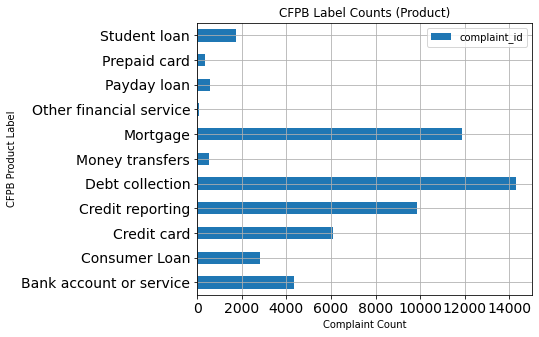

In [23]:
# Product histogram: Normalize to 100% total count
print(f"Total complaints with narrative: {cfpb_train_df.shape[0]:,d}") # ({cwh_notnap:.2f}%)")
title = 'CFPB Label Counts (Product)'
xlabel = 'Complaint Count'
ylabel = 'CFPB Product Label'
# plt.title(title, fontsize=18)
ax = cfpb_train_df.groupby(["product"]).count()[["complaint_id"]].plot(
    kind='barh', figsize=(6,5), grid=True, title=title, ylabel=ylabel,  fontsize=14
)
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

Total complaints with narrative: 52,585


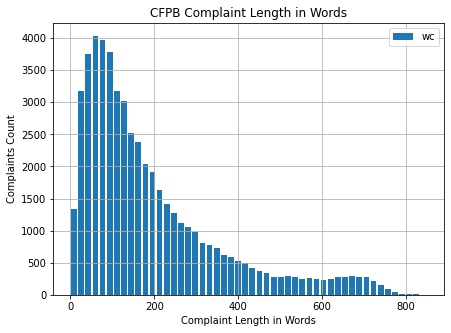

In [24]:
# Histogram: Words
print(f"Total complaints with narrative: {cfpb_train_df.shape[0]:,d}") # ({cwh_notnap:.2f}%)")
title = 'CFPB Complaint Length in Words'
xlabel = 'Complaint Length in Words'
ylabel = 'Complaints Count'

ax = cfpb_train_df.plot(kind="hist", column=['wc'], bins=50, range=(0, 850), 
                        title=title, rwidth=0.8, grid=True, figsize=(7, 5))
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

## Compute CFPB "text" embeddings

* Define document string ("text") to encode
* Select embedding model: FinBERT, Multi-QA-MPNet, MS-MARCO
* Compute dense embeddings

Add complaint_words and concatenated text for embeddings.

concatenated text fields (from cfpb_columns_tcs): 
* date_received, product, issue, company, state, zipcode, consumer_complaint_narrative, complaint_id


In [25]:
%%time
# Add concatenated text column: date_received + product + consumer_complaint_narrative
def concatenate_text(row):
    # str(): Deal with None - TBD at loading()
    text = "date: " + str(row["date_received"]) 
    text += " \n product: " + str(row["product"]) + " \n issue: " + str(row["issue"]) 
    text += " \n company: " + str(row["company"]) 
    text += " \n state: " + str(row["state"]) + " \n zipcode: " + str(row["zipcode"]) 
    text += " \n complaint: " + str(row["consumer_complaint_narrative"])
    return {"text": text}

cfpb_ds = cfpb_ds.map(concatenate_text)
print(f"cfpb_ds.shape: {cfpb_ds.shape}\n")
cfpb_ds

  0%|          | 0/52585 [00:00<?, ?ex/s]

  0%|          | 0/8718 [00:00<?, ?ex/s]

  0%|          | 0/5503 [00:00<?, ?ex/s]

cfpb_ds.shape: {'train': (52585, 11), 'validation': (8718, 11), 'test': (5503, 11)}

CPU times: user 8.23 s, sys: 219 ms, total: 8.45 s
Wall time: 8.46 s


DatasetDict({
    train: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'wc', 'text'],
        num_rows: 52585
    })
    validation: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'wc', 'text'],
        num_rows: 8718
    })
    test: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'wc', 'text'],
        num_rows: 5503
    })
})

In [26]:
# Transformer model: Multi-QA-MPNet or ProsusAI/finbert
model_ckpt = "sentence-transformers/multi-qa-mpnet-base-dot-v1"  # 418 MB, 109M params
# model_ckpt = "ProsusAI/finbert"
tokenizer = hf.AutoTokenizer.from_pretrained(model_ckpt)
model = hf.TFAutoModel.from_pretrained(model_ckpt, from_pt=True)

def cls_pooling(model_output):
    return model_output.last_hidden_state[:, 0]

def get_embeddings(text_list):
    encoded_input = tokenizer(text_list, padding=True, 
                              truncation=True, return_tensors="tf")
    encoded_input = {k: v for k, v in encoded_input.items()}
    model_output = model(**encoded_input)
    return cls_pooling(model_output)

model.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFMPNetModel: ['embeddings.position_ids']
- This IS expected if you are initializing TFMPNetModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFMPNetModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFMPNetModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFMPNetModel for predictions without further training.


Model: "tfmp_net_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mpnet (TFMPNetMainLayer)    multiple                  109486464 
                                                                 
Total params: 109,486,464
Trainable params: 109,486,464
Non-trainable params: 0
_________________________________________________________________


In [27]:
%%time
# Run: Multi-QA-MPNet or ProsusAI/finbert

dataset_save_dir = "./"
dataset_save_dir = "/Users/nelson/dev/nctalks/nlp/search/save/"
faiss_embeddings_dataset_dir = "cfpb_finbert_embeds_20220914"   # FinBERT
faiss_embeddings_dataset_dir = "cfpb_qa_mpnet_embeds_20220916"  # QA MPNet
dataset_path = dataset_save_dir+faiss_embeddings_dataset_dir

run_cell = False   # Change to True to compute embeddings (~5 hours runtime on cpu)
tstart = datetime.now()
if run_cell:
    print(f"Computing embeddings_dataset: {tstart}")
    embeddings_dataset = cfpb_ds.map(
        lambda x: {"embeddings": get_embeddings(x["text"]).numpy()[0]}
    )
    print(f"Saving embeddings: {dataset_path}\n")
    embeddings_dataset.save_to_disk(dataset_dict_path=dataset_path)
else:
    print(f"Loading embeddings: {dataset_path}\n")
    embeddings_dataset = hfds.load_from_disk(dataset_path=dataset_path)

tend = datetime.now()
print(f"TIME start: {tstart}, end: {tend} \nTotal time: {tend-tstart}\n")
print(f"embeddings_dataset.column_names: {embeddings_dataset.column_names}\n")
print(f"embeddings_dataset.shape: {embeddings_dataset.shape}\n")
embeddings_dataset

Loading embeddings: /Users/nelson/dev/nctalks/nlp/search/save/cfpb_qa_mpnet_embeds_20220916

TIME start: 2022-09-25 10:08:06.654886, end: 2022-09-25 10:08:06.714134 
Total time: 0:00:00.059248

embeddings_dataset.column_names: {'train': ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'complaint_words', 'text', 'embeddings'], 'validation': ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'complaint_words', 'text', 'embeddings'], 'test': ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'complaint_words', 'text', 'embeddings']}

embeddings_dataset.shape: {'train': (51401, 12), 'validation': (8534, 12), 'test': (5387, 12)}

CPU times: user 9.1 ms, sys: 14.8 ms, total: 23.9 ms
Wall time: 59.5 ms


DatasetDict({
    train: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'complaint_words', 'text', 'embeddings'],
        num_rows: 51401
    })
    validation: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'complaint_words', 'text', 'embeddings'],
        num_rows: 8534
    })
    test: Dataset({
        features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'complaint_words', 'text', 'embeddings'],
        num_rows: 5387
    })
})

In [28]:
# Last search text
embeddings_dataset["train"]["text"][-1:]

['date: 12/18/2015 \n product: Mortgage \n issue: Loan modification,collection,foreclosure \n company: Citibank \n state: CA \n zipcode: 930XX \n complaint: I am filing a complaint against Citi Mortgage regarding my review for a XXXX loan modification under the HAMP program. I successfully submitted a workout packet to the servicer. I was told repeatedly that I was quote " in review \'\' and that the file was being reviewed for home retention under the Government program. I am currently in a toxic interest only loan that is going to reset and my mortgage payment is going to skyrocket, making it impossible to keep my home. I finally received a decision and spoke with my single point of contact XXXX XXXX who stated. " Because you are not late XXXX XXXX you been denied a loan modification. I was provided the net present value findings, some of which were not even properly reviewed. They were left blank. I have opened up a dispute with Citi Mortgage and am soliciting an official complaint 

## Add FAISS indexing 

Index document collection (CFPB embeddings_dataset["train"])

In [29]:
# FAISS indexing
embeddings_dataset["train"].is_index_initialized(index_name="embeddings")

False

In [30]:
# Add Elasticsearch index
embeddings_dataset["train"].add_faiss_index(column="embeddings")
print(f"embeddings_dataset['train'].shape: {embeddings_dataset['train'].shape}")
print(f"FAISS index initialized: {embeddings_dataset['train'].is_index_initialized(index_name='embeddings')}")

  0%|          | 0/52 [00:00<?, ?it/s]

embeddings_dataset['train'].shape: (51401, 12)
FAISS index initialized: True


In [31]:
embeddings_dataset["train"]

Dataset({
    features: ['date_received', 'product', 'issue', 'consumer_complaint_narrative', 'company', 'state', 'zipcode', 'complaint_id', 'pid', 'complaint_words', 'text', 'embeddings'],
    num_rows: 51401
})

<hr/>

# Embeddings Visualization via UMAP

Embedded text includes structured fields

## Color map
* Data classes, per label


In [32]:
# Data rows to visualize
num_recs = 10000
X_viz = np.array(embeddings_dataset["train"][:num_recs]["embeddings"])
y_viz = np.array(embeddings_dataset["train"][:num_recs]["pid"])
y_viz_names = np.array(embeddings_dataset["train"][:num_recs]["product"])

labels = np.unique(y_viz)
label_names = np.unique(y_viz_names)

print(f"Unique labels: {len(labels)}")
print(f"Labels: {labels}")
print(f"Label names: {label_names}")

Unique labels: 11
Labels: [ 0  1  2  3  4  5  6  7  8  9 10]
Label names: ['Bank account or service' 'Consumer Loan' 'Credit card'
 'Credit reporting' 'Debt collection' 'Money transfers' 'Mortgage'
 'Other financial service' 'Payday loan' 'Prepaid card' 'Student loan']


In [33]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_normalized = sklearn.preprocessing.MinMaxScaler().fit_transform(X_viz) # Scale embeddings to [0,1]
umapper = UMAP(n_components=2, metric="cosine").fit(X_normalized)
X_viz_2d = pd.DataFrame(umapper.embedding_, columns=["X", "Y"])
X_viz_2d["Label"] = y_viz

# UMAP min, max
X_min_max = [X_viz_2d["X"].min(), X_viz_2d["X"].max()]
Y_min_max = [X_viz_2d["Y"].min(),  X_viz_2d["Y"].max()]
print(f"X_min_max: {X_min_max}, Y_min_max: {Y_min_max}")
print(f"Input embeddings shape: {X_viz.shape}, UMAP 2D X_viz_2d shape: {X_viz_2d.shape}\n")

X_viz_2d.head()

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


X_min_max: [-4.8856106, 14.506257], Y_min_max: [-3.5445027, 14.0405035]
Input embeddings shape: (10000, 768), UMAP 2D X_viz_2d shape: (10000, 3)



,X,Y,Label
0,12.901473,3.118240,4
1,10.367685,11.637090,1
2,-2.175003,6.166406,6
3,-1.672962,4.548354,6
4,-1.332795,6.037635,6


In [34]:
# UMAP stats
X_viz_2d.describe(percentiles=[0.5]).T

,count,mean,std,min,50%,max
X,10000.0,5.737819,5.669635,-4.885611,5.236123,14.506257
Y,10000.0,5.706177,3.957396,-3.544503,5.018443,14.040504
Label,10000.0,3.955200,2.282436,0.000000,4.000000,10.000000


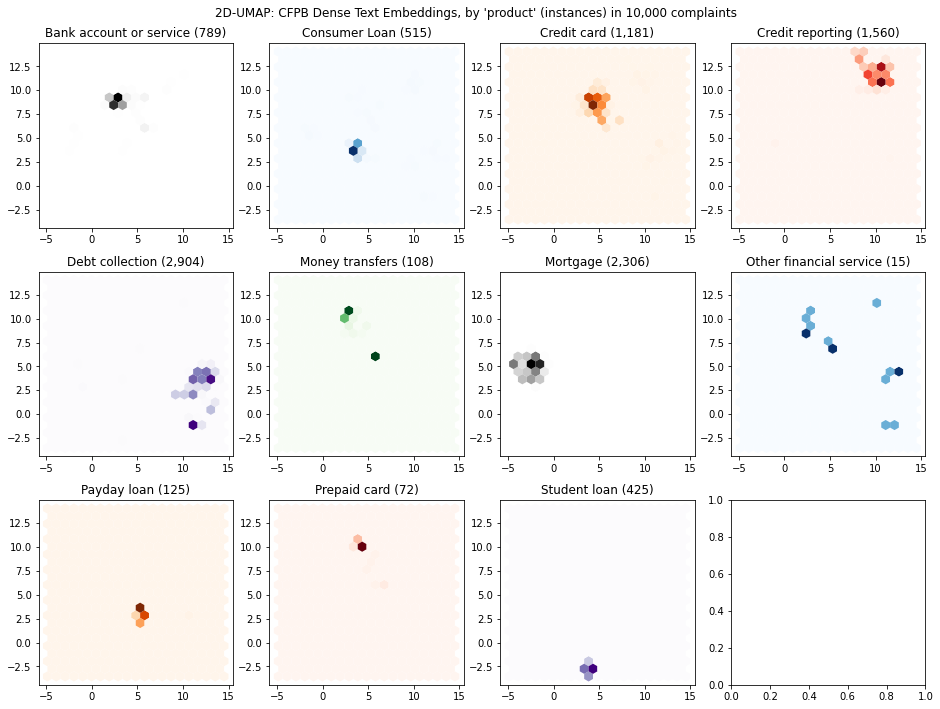

In [35]:
# Plot UMAP: 3x4 rows x cols

figsize = (13, 10)
fig, axes = plt.subplots(3, 4, figsize=figsize)
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens", 
         "Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"
        ]
extent = X_min_max + Y_min_max
title = f"2D-UMAP: CFPB Dense Text Embeddings, by 'product' (instances) in {X_viz_2d.shape[0]:,d} complaints"
plt.suptitle(title)

for i, (label, label_name, cmap) in enumerate(zip(labels, label_names, cmaps)):
    X_viz_2d_sub = X_viz_2d.query(f"Label == {i}")
    axes[i].hexbin(X_viz_2d_sub["X"], X_viz_2d_sub["Y"], # bins="log", 
                   cmap=cmap, extent=extent, gridsize=20, linewidths=(0,))
    sub_label_name = f"{label_name} ({X_viz_2d_sub.shape[0]:,d})"
    axes[i].set_title(sub_label_name)

plt.tight_layout()
plt.show()

<hr/>

# Sample CFPB queries¶



In [36]:
# CFPB dataset question & embed: FinBERT
query = "there is incorrect information on my credit report"
query = "mortgage denied because of discrimination"
query = "bank opened unauthorized account"
%time query_embedding = get_embeddings([query]).numpy()
print(f"query_embedding.shape: {query_embedding.shape}")
pd.DataFrame(query_embedding, columns=None)

CPU times: user 266 ms, sys: 18.4 ms, total: 284 ms
Wall time: 142 ms
query_embedding.shape: (1, 768)


,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,0.00289,-0.260334,-0.230666,0.001826,0.288046,-0.162594,0.301668,-0.276625,0.018368,0.168028,...,-0.074034,0.057401,-0.236056,0.042297,-0.004936,0.019822,0.403327,-0.070349,-0.142917,0.304967


In [37]:
# %%time
# Query search
query = "the bank opened an unauthorized account"
query = "there is incorrect information on my credit report"
%time query_embedding = get_embeddings([query]).numpy()
dsq_column_display = ['date_received', 'product', 'company', 'consumer_complaint_narrative', 
                      'complaint_id', 'score']


# Score and return top-k: FinBERT
num_k = 20
scores, samples = embeddings_dataset["train"].get_nearest_examples(
    "embeddings", query_embedding, k=num_k
)

# Top-k scored results dataframe
print(f"\nQuery: {query}\n")
samples_df = pd.DataFrame.from_dict(samples)
samples_df["score"] = scores
samples_df.sort_values("score", ascending=False, inplace=True, ignore_index=True)
samples_df[dsq_column_display].head()

CPU times: user 295 ms, sys: 14 ms, total: 309 ms
Wall time: 143 ms

Query: there is incorrect information on my credit report



,date_received,product,company,consumer_complaint_narrative,complaint_id,score
0,11/03/2015,Credit reporting,Equifax,I an writing in regards to my credit balance w...,1636731,20.441261
1,09/02/2015,Credit reporting,Equifax,This account was paid Contacted XXXX XXXX twic...,1548154,20.398182
2,08/26/2015,Credit reporting,Equifax,I submitted a fax claiming that it was fraud a...,1538562,20.375984
3,01/01/2016,Credit reporting,Experian,"same as i have been trying to get worked out, ...",1724698,20.355633
4,10/07/2015,Credit reporting,Equifax,I have paid the debt in full and was told by c...,1596236,20.298042


In [40]:
def cfpb_complaint2html(i: int, cid: int, score=0.0, cclen=1000):
    """ cid: complaint_id; return complaint html """
    row_html = ""
    for _, r in cfpb_train_df.query("complaint_id==@cid").iterrows():
        ccn = r.consumer_complaint_narrative[:cclen]
        ccn = ccn.replace('$', '\$').replace('<', '$lt;').replace('>', '&gt;')
        ccn = ccn.replace('\n', '<br/>')
        cidstr, ccn = str(r.complaint_id), ccn 
        row_header = f"<h4>[{i+1:3,d}] - complaint_id: {cidstr}, date: {r.date_received}, score: {score:.2f} </h4>"
        row_ccn = f"<p>{ccn}</p> "
        prod = r["product"] # r.product
        row_tags = f"<p>company: <i>{r.company}</i>, product: <i>{prod}</i>, issue: <i>{r.issue}</i></p>"
        row_html += f"<div> {row_header} \n {row_ccn} \n {row_tags} <hr/> </div>"
    return row_html

def cfpb_display_results(query, results_df, max_results=10, cclen=1000):
    results_html = ""
    results_html += f"<div><h3><i>Query</i>: <span>{query}</span></h3></div>"
    for i, row in samples_df[:max_results].iterrows():
        cid = str(row.complaint_id)
        score = row.score
        results_html += cfpb_complaint2html(i, cid, score=score, cclen=cclen)
    display(HTML(results_html))
    print(f"Dispayed {max_results} results")
    return None

def embeddings_search(query, dc_dataset=embeddings_dataset, top_k=num_k, max_complains=5, cclen=1000):
    query_embedding = get_embeddings([query]).numpy()
    scores, samples = embeddings_dataset["train"].get_nearest_examples(
        "embeddings", query_embedding, k=top_k
    )
    # Top-k scored results dataframe
    samples_df = pd.DataFrame.from_dict(samples)
    samples_df["score"] = scores
    samples_df.sort_values("score", ascending=False, inplace=True, ignore_index=True)
    # Display results
    cfpb_display_results(query, samples_df, max_results=max_complains, cclen=cclen)
    print(f"Collection size: {embeddings_dataset['train'].num_rows:,d}, num_results: {num_k}")
    return None

In [41]:
# Sample queries
query = "the bank opened an unauthorized account"
query = "there is incorrect information on my credit report"

embeddings_search(query, dc_dataset=embeddings_dataset, top_k=num_k, max_complains=5, cclen=1000)

Dispayed 5 results
Collection size: 51,401, num_results: 20


In [ ]:
### EOF